# Approach:

1) Create template of synchro motif, which is fps adjustable
2) Extract timeseries of LED-pixel intensity from each video
3) Match template to extracted timeseries & find best match
4) (Optional?) Check which timeseries of higher fps videos fits best to lower fps videos (i.e. frames 0, 4, 8.. or 1, 5, 9.. or 2, 6, 10..)
5) (Optional?) Synchro stable for the entire video?

# Code development

### 1. Create template of synchro motif

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional
from abc import ABC, abstractmethod

In [ ]:
class TimeseriesTemplate(ABC):

    
    @property
    @abstractmethod
    def template_attribute_string(self) -> str:
        # specifies the attribute name where the template timeseries is saved.
        # will be used by the adjust_template_timeseries_to_fps method
        pass
    
    
    def adjust_template_timeseries_to_fps(self, fps: int) -> List[np.ndarray]:
        template_timeseries = getattr(self, self.template_attribute_string)
        fps_adjusted_templates = []
        framerate = fps/1000
        max_frames = int(template_timeseries.shape[0] * framerate)
        max_offset = 1000 // fps
        for offset_in_ms in range(max_offset):
            image_timestamps = np.linspace(0+offset_in_ms, template_timeseries.shape[0]+offset_in_ms, max_frames, dtype='int')
            while image_timestamps[-1] >= template_timeseries.shape[0]:
                image_timestamps = image_timestamps[:-1]
            adjusted_template = template_timeseries[image_timestamps].copy()
            fps_adjusted_templates.append((adjusted_template, offset_in_ms))
        return fps_adjusted_templates   

In [ ]:
class MotifTemplate(TimeseriesTemplate):
    
    @property
    def template_attribute_string(self) -> str:
        return 'template_timeseries'
    
    
    def __init__(self, led_on_time_in_ms: int, on_off_period_length_in_ms: int, motif_duration_in_ms: int):
        self.led_on_time_in_ms = led_on_time_in_ms
        self.on_off_period_length_in_ms = on_off_period_length_in_ms
        self.motif_duration_in_ms = motif_duration_in_ms
        self.template_timeseries = self._compute_template_timeseries()
        
    
    def _compute_template_timeseries(self) -> np.ndarray:
        led_on_off_period = np.zeros((self.on_off_period_length_in_ms), dtype='float')
        led_on_off_period[1:self.led_on_time_in_ms+1] = 1
        full_repetitions = self.motif_duration_in_ms // self.on_off_period_length_in_ms
        remaining_ms = self.motif_duration_in_ms % self.on_off_period_length_in_ms
        motif_template = np.concatenate([led_on_off_period]*(full_repetitions+1))
        adjusted_end_index = self.on_off_period_length_in_ms*full_repetitions + remaining_ms
        return motif_template[:adjusted_end_index]

In [ ]:
class SessionTemplate(TimeseriesTemplate):
    
    @property
    def template_attribute_string(self) -> str:
        return 'whole_session_template'
    
    
    def __init__(self) -> None:
        self.motif_templates = []
    
    
    def _compute_template_timeseries(self) -> Optional[np.ndarray]:
        if len(self.motif_templates) > 0:
            return self._concatenate_motif_templates()
        else:
            return None
        
    
    def add_motif_template(self, motif_template: MotifTemplate) -> None:
        self.motif_templates.append(motif_template)
        self.whole_session_template = self._update_session_template()
    
    
    def _update_session_template(self) -> np.ndarray:
        individual_motif_template_timeseries = [elem.template_timeseries for elem in self.motif_templates]
        return np.concatenate(individual_motif_template_timeseries)

In [ ]:
template = MotifTemplate(led_on_time_in_ms=50, on_off_period_length_in_ms=100, motif_duration_in_ms=8_000)
template2 = MotifTemplate(led_on_time_in_ms=80, on_off_period_length_in_ms=1000, motif_duration_in_ms=590_000)

session_template = SessionTemplate()
session_template.add_motif_template(motif_template = template)
session_template.add_motif_template(motif_template = template2)

session_template.whole_session_template.shape

In [ ]:
adjusted_session_templates = session_template.adjust_template_timeseries_to_fps(fps = 160)
adjusted_session_templates[0][0].shape

In [ ]:
plt.plot(adjusted_session_templates[0][0][:1600])
plt.show()

### 2. Extract timeseries of LED-pixel intensity

cropping_indices:

- bottom (10/08):   468:475, 523:531  -->
- bottom (11/08):   505:515, 570:590  --> 509, 581
- bottom_b (11/08 - after bump in synchro): 530:540, 555:565 --> 536, 561
- top (10 & 11/08): 245:255, 429:437  --> 249, 433
- side1 (11/08):    295:305, 555:565  --> 299, 560
- side2 (11/08):    287:300, 300:310  --> 293, 304

In [2]:
import imageio as iio
import ffmpeg
from pathlib import Path
import os
import numpy as np
from typing import List, Tuple, Optional

import sys
sys.path.append('/home/ds/GitHub_repos/rapidAligner/')

import rapidAligner as ra
import cupy as cp

In [1]:
import imageio as iio
import matplotlib.pyplot as plt
%matplotlib widget

In [ ]:
coords = {'bottom_crop': (503, 670),
          'bottom_nocrop': (823, 834),
          'Side1_crop': (456, 1168),
          'Side1_nocrop': (456, 1168),
          'Side2_crop': (425, 751),
          'Side2_nocrop': (425, 751),
          'top_crop': (336, 537),
          'top_nocrop': (336, 537)}

In [63]:
filepath_video = '/mnt/c/Users/dsege/Downloads/OneDrive_2022-08-18/Setup_Test_220818/calibration_top_nocrop002.AVI'
for i, frame in enumerate(iio.v3.imiter(filepath_video)):
    if i > 0:
        break

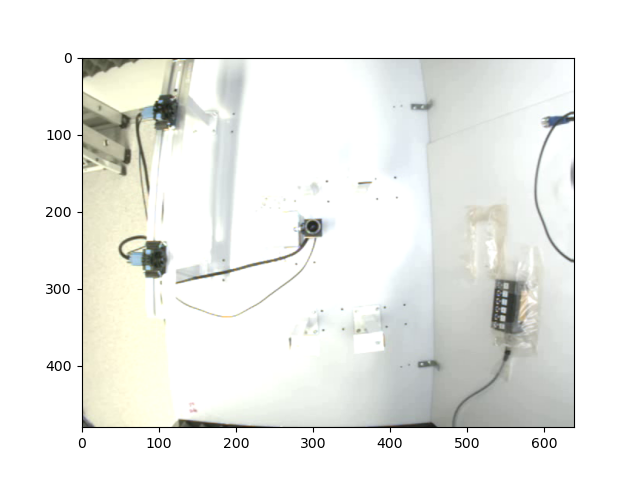

In [64]:
plt.close()
plt.imshow(frame)

In [13]:
plt.close()

In [ ]:
plt.imshow(frame[287:300, 300:310])
plt.scatter(4, 6)

In [ ]:
class SingleCamRawCalibrationData:
    
    def __init__(self, filepath_video: Path, filepath_tracking: Path, led_marker_id: str, box_rows: int=5, box_cols: int=5) -> None:
        self.filepath_video = filepath_video
        self.filepath_tracking = filepath_tracking
        self.led_marker_id = led_marker_id
        self.fps = self._load_fps_from_video_metadata()
        self.led_center_pixel_coords = self._get_led_center_pixel_coords()
        self.led_timeseries = self._extract_led_pixel_intensities(box_rows = box_rows, box_cols = box_cols)
        
        
    def _load_fps_from_video_metadata(self) -> int:
        fps = iio.v3.immeta(filepath_video)['fps']
        if fps % 1 != 0:
            print(f'Warning! The fps of the video is not an integer! -> fps: {fps}')
        return int(fps)
        
    
    def _get_led_center_pixel_coords(self) -> Tuple[int, int]:
        # load dlc output file
        # go over all predicted led marker positions
        # calculate median position from those with highest prediction probabilities
        # and confirm that they don´t include large shifts (e.g. very low z-scores only)
        # return format has to be (row_index, column_index)
        # for now, this will solely return the manually determined coords:
        coords = {'top': (249, 433),
                  'bottom': (509, 581),
                  'bottom_b': (536, 561),
                  'side1': (299, 560),
                  'side2': (293, 304)}
        return coords[self.led_marker_id]
    
    
    def _extract_led_pixel_intensities(self, box_rows: int, box_cols: int) ->np.ndarray:
        box_row_indices = self._get_start_end_indices_from_center_coord_and_length(center_px = self.led_center_pixel_coords[0],
                                                                                       length = box_rows)
        box_col_indices = self._get_start_end_indices_from_center_coord_and_length(center_px = self.led_center_pixel_coords[1],
                                                                                       length = box_cols)
        mean_pixel_intensities = []
        for frame in iio.v3.imiter(self.filepath_video):
            box_mean_intensity = frame[box_row_indices[0]:box_row_indices[1], 
                                       box_col_indices[0]:box_col_indices[1]].mean()
            mean_pixel_intensities.append(box_mean_intensity)
        return np.asarray(mean_pixel_intensities)
                        
                        
    def _get_start_end_indices_from_center_coord_and_length(self, center_px: int, length: int) -> Tuple[int, int]:
        start_index = center_px - (length // 2)
        end_index = center_px + (length - (length // 2))
        return start_index, end_index
    
    
    def find_best_match_of_motif_template(self, motif_template: MotifTemplate, start_time: int=0, end_time: int=-1, plot_result: bool=True) -> Tuple[int, int]:
        # ToDo: optional arguments to specify interval where the motif has to be found?
        adjusted_motif_timeseries = motif_template.adjust_template_timeseries_to_fps(fps = self.fps)
        start_frame_idx = self._get_frame_index_clostest_to_time(time = start_time)
        end_frame_idx = self._get_frame_index_clostest_to_time(time = end_time)
        best_match_offset, best_match_start_idx = self._get_offset_and_start_index_of_best_match(adjusted_templates = adjusted_motif_timeseries,
                                                                                                 start_frame_idx = start_frame_idx, 
                                                                                                 end_frame_idx = end_frame_idx)
        if plot_result:
            self._plot_best_alignment_result(template = adjusted_motif_timeseries[best_match_offset][0], start_idx = best_match_start_idx)
        return best_match_offset, best_match_start_idx
    
    
    #ToDo: find_best_match_of_session_template()
    
    
    def _get_frame_index_clostest_to_time(self, time: int) -> int:
        time_error_message = (f'The specified time: {time} is invalid! Both times have to be an integer '
                              'larger than -1, where -1 represents the very last timestamp in the video '
                              'and every other integer (e.g.: 1000) the time in ms. Please be aware, that '
                              '"start_time" has to be larger than "end_time" (with end_time == -1 as only '
                              'exception) and must be smaller or equal to the total video recording time.')
        if time == -1:
            return -1
        else:
            if time < 0:
                raise ValueError(time_error_message)
            framerate = 1000 / self.fps
            closest_frame_idx = round(time / framerate)
            if closest_frame_idx >= self.led_timeseries.shape[0]:
                raise ValueError(time_error_message)
            return closest_frame_idx

        
    def _get_offset_and_start_index_of_best_match(self, adjusted_templates: List[Tuple[np.ndarray, int]], start_frame_idx: int, end_frame_idx: int) -> Tuple[int, int]:
        lowest_sum_of_squared_error_per_template = []
        for template_timeseries, _ in adjusted_templates:
            alignment_results = self._run_rapid_aligner(query = template_timeseries, subject = self.led_timeseries[start_frame_idx:end_frame_idx])
            alignment_results_as_np_array = alignment_results.get()
            lowest_sum_of_squared_error_per_template.append(alignment_results_as_np_array.min())
        lowest_sum_of_squared_error_per_template = np.asarray(lowest_sum_of_squared_error_per_template)
        best_matching_template_index = int(lowest_sum_of_squared_error_per_template.argmin())
        best_alignment_results = self._run_rapid_aligner(query=adjusted_templates[best_matching_template_index][0], subject=self.led_timeseries[start_frame_idx:end_frame_idx])
        start_index = int(best_alignment_results.argmin())
        return best_matching_template_index, start_index


    def _run_rapid_aligner(self, query: np.ndarray, subject: np.ndarray) -> np.ndarray:
        subject_timeseries_gpu = cp.asarray(subject)
        query_timeseries_gpu = cp.asarray(query)
        # run on (global) min-max normalized timeseries, assuming that
        # led flashes have more or less the max values? board interference?
        return ra.ED.zdist(query_timeseries_gpu, subject_timeseries_gpu, mode="fft")
    
    
    def _plot_best_alignment_result(self, template: np.ndarray, start_idx: int) -> None:
        end_idx = start_idx + template.shape[0]
        fig = plt.figure(figsize=(15, 10), facecolor='white')
        gs = fig.add_gridspec(2, 1)
        ax_raw = fig.add_subplot(gs[0,0])
        ax_raw.plot(self.led_timeseries[start_idx:end_idx])
        ax_raw.plot(template)
        ax_zscored = fig.add_subplot(gs[1,0])
        ax_zscored.plot(self._zscore(array = self.led_timeseries[start_idx:end_idx]))
        ax_zscored.plot(self._zscore(array = template))
        plt.show()
        
        
    def _zscore(self, array: np.ndarray) -> np.ndarray:
        return (array-np.mean(array))/np.std(array, ddof=0)
    
    
    def write_synchronized_and_fps_adjusted_calibration_video(self, start_frame_idx: int, offset: int, target_fps: int) -> None:
        original_ms_per_frame = self._get_ms_interval_per_frame(fps = self.fps)
        led_timeseries_synchronized_to_motif_start = self._crop_led_timeseries_to_motif_start(start_frame_idx = start_frame_idx, offset = offset)
        offset_adjusted_timestamps_synchronized_led_timeseries = self._adjust_timestamps_for_offset(offset = offset, 
                                                                                                    synchronized_timeseries = led_timeseries_synchronized_to_motif_start)
        target_fps_adjusted_timestamps = self._get_timestamps_of_target_fps(target_fps = target_fps, 
                                                                            synchronized_timeseries = led_timeseries_synchronized_to_motif_start)
        idxs_of_frames_to_sample = self._find_frame_idxs_closest_to_target_timestamps(target_timestamps = target_fps_adjusted_timestamps, 
                                                                                      original_timestamps = offset_adjusted_timestamps_synchronized_led_timeseries)
        self.synchronized_and_fps_adjusted_led_timeseries = led_timeseries_synchronized_to_motif_start[idxs_of_frames_to_sample]
        idxs_of_frames_to_sample_adjusted_for_synchronization = self._adjust_frame_idxs_for_synchronization(frame_idxs = idxs_of_frames_to_sample,
                                                                                                            start_frame_idx = start_frame_idx,
                                                                                                            offset = offset)
        frame_idxs_per_part = self._split_into_ram_digestable_parts(idxs_of_frames_to_sample = idxs_of_frames_to_sample_adjusted_for_synchronization, max_frame_count = 3000)
        self._initiate_writing_of_individual_video_parts(frame_idxs_per_part = frame_idxs_per_part, target_fps = 30) 
    
    
    def _get_ms_interval_per_frame(self, fps: int) -> float:
        return 1000 / fps
    
        
    def _crop_led_timeseries_to_motif_start(self, start_frame_idx: int, offset: int) -> np.ndarray:
        offset_adjusted_start_frame_idx = start_frame_idx + self._get_n_frames_to_adjust_for_offset(offset = offset)
        return self.led_timeseries[offset_adjusted_start_frame_idx:].copy()
                                                                                                            
        
    def _get_n_frames_to_adjust_for_offset(self, offset: int) -> int:
        return round(offset/self.fps)
    
    
    def _adjust_timestamps_for_offset(self, offset: int, synchronized_timeseries: np.ndarray) -> np.ndarray:
        original_ms_per_frame = self._get_ms_interval_per_frame(fps = self.fps)
        n_frames_to_adjust_for_offset = self._get_n_frames_to_adjust_for_offset(offset = offset)
        updated_offset_after_frame_adjustment = offset - n_frames_to_adjust_for_offset*original_ms_per_frame
        offset_adjusted_timestamps_led_series = np.arange((synchronized_timeseries.shape[0])*original_ms_per_frame, step=original_ms_per_frame)
        return offset_adjusted_timestamps_led_series + updated_offset_after_frame_adjustment
        
    
    def _get_timestamps_of_target_fps(self, target_fps: int, synchronized_timeseries: np.ndarray) -> np.ndarray:
        target_ms_per_frame = self._get_ms_interval_per_frame(fps = target_fps)
        original_ms_per_frame = self._get_ms_interval_per_frame(fps = self.fps)
        max_frames = int((synchronized_timeseries.shape[0] * original_ms_per_frame) / target_ms_per_frame)
        return np.arange(max_frames*target_ms_per_frame, step=target_ms_per_frame)
        
        
    def _find_frame_idxs_closest_to_target_timestamps(self, target_timestamps: np.ndarray, original_timestamps: np.ndarray) -> List[int]:
        frame_indices_closest_to_target_timestamps = []
        for timestamp in target_timestamps:
            closest_frame_index = self._find_closest_timestamp_index(original_timestamps=original_timestamps, timestamp=timestamp)
            frame_indices_closest_to_target_timestamps.append(closest_frame_index)
        return frame_indices_closest_to_target_timestamps
    

    def _find_closest_timestamp_index(self, original_timestamps: np.ndarray, timestamp: float) -> int:
        return np.abs(original_timestamps - timestamp).argmin()
    
    
    def _adjust_frame_idxs_for_synchronization(self, frame_idxs: List[int], start_frame_idx: int, offset: int) -> List[int]:
        offset_adjusted_start_frame_idx = start_frame_idx + self._get_n_frames_to_adjust_for_offset(offset = offset)
        frame_idxs_array = np.asarray(frame_idxs)
        offset_adjusted_frame_idxs = frame_idxs_array + offset_adjusted_start_frame_idx
        return list(offset_adjusted_frame_idxs)
        
        
    def _split_into_ram_digestable_parts(self, idxs_of_frames_to_sample: List[int], max_frame_count: int) -> List[List[int]]:
        frame_idxs_per_part = []
        while len(idxs_of_frames_to_sample) > 3000:
            frame_idxs_per_part.append(idxs_of_frames_to_sample[:3000])
            idxs_of_frames_to_sample = idxs_of_frames_to_sample[3000:]
        frame_idxs_per_part.append(idxs_of_frames_to_sample)
        return frame_idxs_per_part
    
    
    def _initiate_writing_of_individual_video_parts(self, frame_idxs_per_part: List[List[int]], target_fps: int) -> None:
        for idx, idxs_of_frames_to_sample in enumerate(frame_idxs_per_part):
            part_id = str(idx).zfill(3)
            self._write_video_to_disk(idxs_of_frames_to_sample = idxs_of_frames_to_sample, target_fps = target_fps, part_id = part_id)
        
        
    def _write_video_to_disk(self, idxs_of_frames_to_sample: List[int], target_fps: int, part_id: Optional[int]=None) -> None:
        selected_frames = []
        print('load original video')
        for i, frame in enumerate(iio.v3.imiter(filepath_video)):
            if i in idxs_of_frames_to_sample:
                selected_frames.append(frame)
        video_array = np.asarray(selected_frames)
        if part_id == None:
            filepath_out = self.filepath_video.parent.joinpath(f'{self.led_marker_id}_cam_synchronized_for_calibration.mp4')
        else:
            filepath_out = self.filepath_video.parent.joinpath(f'{self.led_marker_id}_cam_synchronized_for_calibration_part_{part_id}.mp4')
        print('writing video to disk')
        iio.mimwrite(filepath_out, video_array, fps=target_fps)
        print('done!')

In [ ]:
filepath_video = Path('/mnt/c/Users/dsege/Downloads/194_F8-15_220811_OTE/194_F8-15_220811_OTE/194_F8-15_220811_OTE_bottom.mp4')
cam_raw_calib_data = SingleCamRawCalibrationData(filepath_video = filepath_video,
                                                 filepath_tracking = 'n.a.',
                                                 led_marker_id = 'bottom_b')

In [ ]:
plt.plot(cam_raw_calib_data.led_timeseries)

In [ ]:
if cam_raw_calib_data.fps == 160:
    cam_raw_calib_data.fps = 125

In [ ]:
best_match_offset, best_match_start_idx = cam_raw_calib_data.find_best_match_of_motif_template(motif_template=template, end_time = 20_000)

In [ ]:
best_match_start_idx / cam_raw_calib_data.fps

In [ ]:
cam_raw_calib_data.write_synchronized_and_fps_adjusted_calibration_video(start_frame_idx = best_match_start_idx, offset = best_match_offset, target_fps = 30)


In [ ]:
cam_raw_calib_data.synchronized_and_fps_adjusted_led_timeseries.shape

In [ ]:
synchronized_led_timeseries[cam_raw_calib_data.led_marker_id] = cam_raw_calib_data.synchronized_and_fps_adjusted_led_timeseries

In [ ]:
video_dir_path = Path('/mnt/c/Users/dsege/Downloads/OneDrive_2022-08-11/Calibration_220811/Calibration_220811_OTE_CalibrationSide2_7X5.mp4')
coords = {'top': (249, 433),
          'bottom': (509, 581),
          'side1': (299, 560),
          'side2': (293, 304)}

In [ ]:
org_video_filenames = {'top': 'Calibration_220811_OTE_CalibrationTop_7X5003.AVI',
                       'bottom': 'Calibration_220811_OTE_CalibrationBottom_7X5.mp4',
                       'side1': 'Calibration_220811_OTE_CalibrationSide1_7X5.mp4',
                       'side2': 'Calibration_220811_OTE_CalibrationSide2_7X5.mp4'}

In [ ]:
extracted_original_led_traces = []
for camera_id in coords.keys():
    video_filename = org_video_filenames[camera_id]
    filepath_video = video_dir_path.joinpath(video_filename)
    led_trace = load_led_trace(led_center_pixel_coords = coords[camera_id], filepath_video = filepath_video)
    extracted_original_led_traces.append(led_trace)

In [ ]:
extracted_led_traces = []
for camera_id in coords.keys():
    video_filename = f'{camera_id}_cam_synchronized_for_calibration.mp4'
    filepath_video = video_dir_path.joinpath(video_filename)
    led_trace = load_led_trace(led_center_pixel_coords = coords[camera_id], filepath_video = filepath_video)
    extracted_led_traces.append(led_trace)

In [ ]:
def load_led_trace(led_center_pixel_coords: Tuple[int, int], filepath_video: Path) -> np.ndarray:
    box_row_indices = _get_start_end_indices_from_center_coord_and_length(center_px = led_center_pixel_coords[0],
                                                                                   length = 4)
    box_col_indices = _get_start_end_indices_from_center_coord_and_length(center_px = led_center_pixel_coords[1],
                                                                                   length = 4)
    mean_pixel_intensities = []
    for frame in iio.v3.imiter(filepath_video):
        box_mean_intensity = frame[box_row_indices[0]:box_row_indices[1], 
                                   box_col_indices[0]:box_col_indices[1]].mean()
        mean_pixel_intensities.append(box_mean_intensity)
    return np.asarray(mean_pixel_intensities)

def _get_start_end_indices_from_center_coord_and_length(center_px: int, length: int) -> Tuple[int, int]:
    start_index = center_px - (length // 2)
    end_index = center_px + (length - (length // 2))
    return start_index, end_index

In [ ]:
resampled_led_traces = []
for led_trace in extracted_original_led_traces:
    if led_trace.shape[0] > 5000:
        resampled_led_traces.append(led_trace[resample_idxs])
    else:
        resampled_led_traces.append(led_trace)

In [ ]:
fig = plt.figure(figsize=(25, 10))
for led_trace in resampled_led_traces:
    plt.plot(led_trace, alpha=0.4)
plt.xlim(0,200)
plt.show()

In [ ]:
fig = plt.figure(figsize=(25, 10))
for led_trace in extracted_led_traces:
    plt.plot(led_trace, alpha=0.4)
plt.xlim(0,200)
plt.show()

In [ ]:
synchronized_led_timeseries

In [ ]:
fig = plt.figure(figsize=(25, 10))
for camera_id in synchronized_led_timeseries.keys():
    plt.plot(synchronized_led_timeseries[camera_id], label=camera_id, alpha=0.4)
plt.xlim(0,60)
plt.show()

#### Concatenate individual video parts

In [8]:
part1 = ffmpeg.input('/mnt/c/Users/dsege/Downloads/194_F8-15_220811_OTE/194_F8-15_220811_OTE/side2_cam_synchronized_for_calibration_part_000.mp4')
part2 = ffmpeg.input('/mnt/c/Users/dsege/Downloads/194_F8-15_220811_OTE/194_F8-15_220811_OTE/side2_cam_synchronized_for_calibration_part_001.mp4')
part3 = ffmpeg.input('/mnt/c/Users/dsege/Downloads/194_F8-15_220811_OTE/194_F8-15_220811_OTE/side2_cam_synchronized_for_calibration_part_002.mp4')
part4 = ffmpeg.input('/mnt/c/Users/dsege/Downloads/194_F8-15_220811_OTE/194_F8-15_220811_OTE/side2_cam_synchronized_for_calibration_part_003.mp4')
part5 = ffmpeg.input('/mnt/c/Users/dsege/Downloads/194_F8-15_220811_OTE/194_F8-15_220811_OTE/side2_cam_synchronized_for_calibration_part_004.mp4')
part6 = ffmpeg.input('/mnt/c/Users/dsege/Downloads/194_F8-15_220811_OTE/194_F8-15_220811_OTE/side2_cam_synchronized_for_calibration_part_005.mp4')

all_parts = [part1, part2, part3, part4, part5, part6]

In [9]:
all_frames = ffmpeg.concat(all_parts[0], all_parts[1])
for part in all_parts[2:]:
    all_frames = ffmpeg.concat(all_frames, part)
    

In [10]:
out = ffmpeg.output(all_frames, '/mnt/c/Users/dsege/Downloads/194_F8-15_220811_OTE/194_F8-15_220811_OTE/side2_cam_synchronized_for_calibration_all_parts.mp4')

In [11]:
out.run(overwrite_output = True)

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

(None, None)

### 3. Match template synchro motif to extracted timeseries

Well, see cells above :-)